In [1]:
import tensorflow as tf
import numpy as np
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers as ly
import time
from IPython import display

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [4]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

batching & shuffling the data

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator():
    model = tf.keras.Sequential([
        ly.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Reshape((7, 7, 256)),
        
        ly.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        ly.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    return model

In [11]:
generator = make_generator()

In [12]:
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)

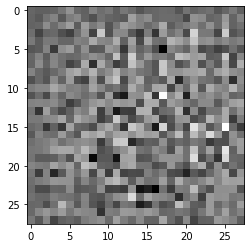

In [13]:
import matplotlib.pyplot as plt

plt.imshow(gen_img[0, :, :, 0], cmap="gray")

In [14]:
def make_discriminator():
    model = tf.keras.Sequential([
        ly.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Flatten(),
        ly.Dense(1)
    ])
    return model

In [15]:
discriminator = make_discriminator()

In [16]:
decision = discriminator(gen_img)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00491676]], dtype=float32)>

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metoda określa ilościowo, jak dobrze dyskryminator jest w stanie odróżnić prawdziwe obrazy od podróbek

Porwnuje przewidywania dyskriminatora dotyczce rzeczywistych obrazw z tablic jedynek, a przewidywania dyskryminatora dotyczce faszywych (generowanych obrazów z tablicą zer.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = crss_entropy(tf.ones_like(real_output), real_output)
    fake_loss = crss_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator loss określa ilościowo, jak dobre był on  w stanie oszukać dyskryminator. Intuicyjnie, jeśli generator działa dobrze, dyskryminator sklasyfikuje fałszywe obrazy jako rzeczywiste (lub 1). Tutaj porównamy decyzje dyskryminatorów na wygenerowanych obrazach z tablicą jedynek.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [30]:
EPOCHS = 50
noise_dims = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dims])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dims])
    
    with tf.GradientTape() as gen_taoem tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    grads_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)